## **Lab 10: Automatic Estimation of Vanishing Points**

In this lab, we are implementing an approach of estimating vanishing points from Section 4 of http://slazebni.cs.illinois.edu/spring19/3dscene_book_svg.pdf.

You can also check the following papers for more details:
1. Rother, Carsten. "A new approach to vanishing point detection in architectural environments." Image and Vision Computing 20.9-10 (2002): 647-655.
2. Hedau, Varsha, Derek Hoiem, and David Forsyth. "Recovering the spatial layout of cluttered rooms." 2009 IEEE 12th international conference on computer vision. IEEE, 2009.

For estimating intrinsic camera parameters given three orthogonal vanishing points, we have implemented an algorithm following page 226 from the book:

Hartley, Richard, and Andrew Zisserman. Multiple view geometry in computer vision. Cambridge university press, 2003.

In [1]:
import numpy as np
import cv2
import itertools
from math import isclose
import matplotlib.pyplot as plt

We provide some helper functions below for image display, line detection and camera intrinsic matrix estimation given three vanishing points.

In [ ]:
def displayImage(img: np.array, window_name: str = "Display window") -> None:
    '''
        Display an image in a numpy array using cv2.
        Note: cv2 assumes images to be stored in HxWxC and BGR format
        if the images are in float, they are assumed to be in 0-1
        range.
        
        
        :param img: Image to display stored in a numpy array
        :param window_name: Name to display on the window
    '''
    
    # Run locally
    cv2.namedWindow(window_name, cv2.WINDOW_AUTOSIZE)
    cv2.imshow(window_name, img)
    # Wait for a key event infinitely
    cv2.waitKey(0)

    # Close all open windows  
    cv2.destroyAllWindows()  
    # For mac users, uncomment the following line
    cv2.waitKey(1)
    
    # Run in google colab
    # from google.colab.patches import cv2_imshow
    # cv2_imshow(img)

def detect_lines(image: np.array) -> np.array: 
    '''
        Detect lines in the given image.
        :param image: image stored in a numpy array
    '''
    # Convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Blur image to reduce noise.
    image = cv2.GaussianBlur(image, (5, 5), 1)
    # Detect edges
    edges = cv2.Canny(image, 50, 150)
    # Detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, None, 50, 5) # This function is used to detect lines in the image
    
    print(len(lines))
    return edges, lines

def estimate_K(vp1: np.array, vp2: np.array, vp3: np.array) -> np.array:
    '''
        Estimate intrinsic camera parameters given three vanishing points
        See Multiple View Geometry in Computer Vision (pag. 226) 
        
        :param vp1: first vanishing point
        :param vp2: second vanishing point
        :param vp3: third vanishing point
    '''
    try:
        A = []
        for (p1, p2) in itertools.combinations([vp1, vp2, vp3], 2):
            A.append([p1[0]*p2[0]+p1[1]*p2[1], p1[0]*p2[2]+p1[2]*p2[0], p1[1]*p2[2]+p1[2]*p2[1], p1[2]*p2[2]])
        u, s, v = np.linalg.svd(A, full_matrices=True)
        w1, w2, w3, w4 = v[-1,:]
        # form the omega matrix
        w = np.array([[w1, 0., w2],
                      [0., w1, w3],
                      [w2, w3, w4]])
        # w = (KK^T)^-1
        # K can be obtained by Cholesky factorization
        K_transpose_inv = np.linalg.cholesky(w)
        K = np.linalg.inv(K_transpose_inv.T)
        K = K / K[-1, -1]
    except:
        return []
    
    return K

Let's start by obtaining the line features that we need in our computations.

In [8]:
def process_lines(pts: np.array) -> np.array:
    '''
        Process line features.

        :param pts: x,y coordinates of the points, which is a Nx2 array.
        :return :lines formed by the points, whcih is a Nx12 array. 

        Represent lines as the following tuple
        (pt1, pt2, a, b, c, m, l, theta)
        where pt1, pt2 are endpoints in homogeneous coordinates, a, b, c are coefficient of line equation ax + by + c = 0, 
        m is the midpoint of the line segment, l is the length of line segment 
        theta is the angle between the line and x axis
    '''
    
    # Points in homogeneous coordinates
    pt1 = np.concatenate((pts[:, 0, :2], np.ones((len(pts), 1))), axis=1)
    pt2 = np.concatenate((pts[:, 0, 2:], np.ones((len(pts), 1))), axis=1)

    # line equation (a, b, c) = pt1 x pt2  
    # Hint: check np.cross
    line_eq = np.cross(pt1, pt2) # N by 3

    # midpoint
    m = (pt1[:, :2] + pt2[:, :2]) / 2  # N by 3

    # length of the line segment
    l = np.linalg.norm(pt2[:, :2] - pt1[:, :2], axis=1, keepdims=True) # N by 1

    # angle 
    theta = np.reshape([np.arctan(-a / b) if b != 0 else np.pi/2 for (a, b, c) in line_eq], (-1, 1)) # N by 1, measured in radians

    # concatenate all features
    lines = np.concatenate([pt1, pt2, line_eq, m, l, theta], axis=1) # N by 12
    
    return lines

Then, we try to find possible vanishing points using the line features. The score for a vanishing point candidate $vp_j$ is 

$s_j=\sum_{i}|l_i|\exp(-\frac{|\alpha_i-\theta_i|}{2\sigma^2})$. 

$|l_i|$ is the length of line segment $i$. $\alpha_i$ is the angle of the line that connects the midpoint of the line segment to the vanishing point in radians. $\theta$ is the angle of the line segment. $\sigma$ is a scale parameter.  

In [9]:
def compute_candidate_vp(lines: np.array) -> np.array:
    '''
        Compute vanishing point candidates and their scores.

        :param lines: lines stored in a numpy array: (pt1, pt2, a, b, c, m, l, theta)
        :return:  candidate vanishing points and scores
    '''
    
    sigma = 0.1 # scaling parameter
    vp_candidates = []
    for pair in itertools.combinations(lines,2):
        # pair: a tuple of (line1,line2)
        # candidate of vanishing point: intersection of two lines = line1 (a,b,c) x line2 (a,b,c)
        # vp uses homogeneous coordinate, which should be an array of size 3
        vp = np.cross(pair[0][6:9], pair[1][6:9]) # 3 by 1

        # normalize vp 
        vp = vp / vp[-1] if vp[-1] != 0 else vp

        # assert isclose(np.dot(vp, pair[0][6:9]), 0, abs_tol=1e-09) and isclose(np.dot(vp, pair[1][6:9]), 0, abs_tol=1e-09) 
        assert isclose(np.dot(vp, pair[0][6:9]), 0, abs_tol=1e-09) and isclose(np.dot(vp, pair[1][6:9]), 0, abs_tol=1e-09) 

        score = 0
        for line in lines:
            # line (a,b,c) from vp to the midpoint of line segment
            line_vp2mp = np.cross(line[9:12], vp)

            # angle of the line
            vec1 = line_vp2mp[:2]
            vec2 = line[6:8]  # a, b from (a, b, c)
            dot = np.dot(vec1, vec2)
            norm1 = np.linalg.norm(vec1)
            norm2 = np.linalg.norm(vec2)
            cos_alpha = dot / (norm1 * norm2 + 1e-8)
            alpha = np.arccos(np.clip(cos_alpha, -1, 1))  # radians

            # obtain score using alpha and sigma
            score += np.exp(-(alpha ** 2) / (2 * sigma ** 2))
        vp_candidates.append((vp, score))

        # compute score
        score = 0


    return vp_candidates


Now that we have vanishing points candidates, we can choose the best vanishing points triplet with the highest total score that also leads to reasonable camera parameters. Recall that $K$ is
\begin{bmatrix}
f_x &s &c_x\\
0 &f_y &c_y\\
0 &0 &1
\end{bmatrix} 

In [21]:
def choose_vp(vp_candidates: np.array) -> np.array:
    '''
        Choose the triplet of vanishing points candidates with the highest score 
        that also leads to reasonable camera parameters.

        :param vp_candidates: candidate vanishing points and scores, each vp_candidate
        is a tuple of (vp_coordinate,score)
        :return: the final intrisic camera parameters and its corresponding vanishing points triplet
    '''
    max_score = 0
    final_K = []
    max_triplet = []

    # sort vanishing points by their scores in a DESCENDING order
    vp_candidates = sorted(vp_candidates, key=lambda x: x[1], reverse=True)
    
    first_vp = vp_candidates[0]

    # choose the triplet of vanishing points 
    for pair in itertools.combinations(vp_candidates[1:],2):
        total_score = first_vp[1] + pair[0][1] + pair[1][1]
        K = estimate_K(first_vp[0], pair[0][0], pair[1][0])
        if len(K) > 0:
            # decide if the estimated camera intrisinc matrix K is proper            
            if np.all(np.isreal(K)) and K[0,0] > 0 and K[1,1] > 0 and abs(K[0,1]) < 1e-3:               
                if total_score > max_score:
                    max_score = total_score
                    final_K = K
                    max_triplet = (
                        first_vp[0][:2].reshape(1, 2),
                        pair[0][0][:2].reshape(1, 2),
                        pair[1][0][:2].reshape(1, 2)
                    ) # combine three vanishing points

    return final_K, max_triplet

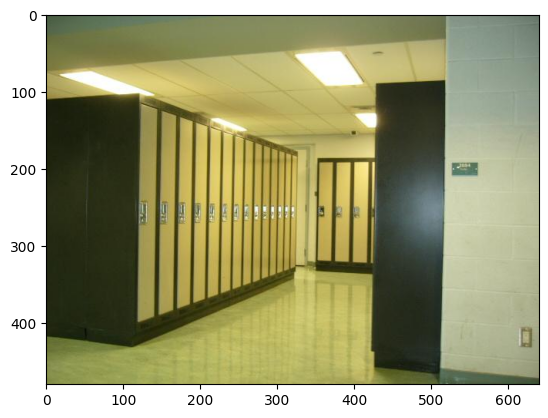

In [5]:
image = cv2.imread('scene.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

36


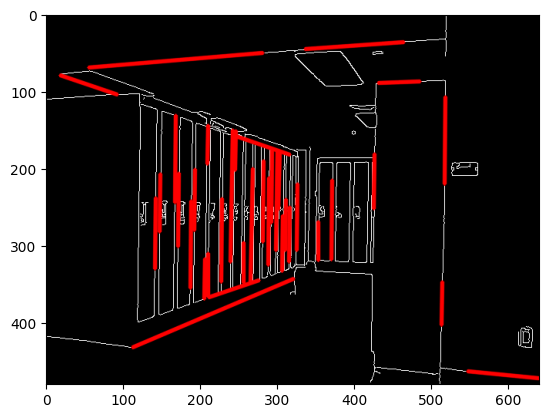

In [22]:
edges, lines = detect_lines(image)
# Draw edges and lines
canvas = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
if lines is not None:
    for i in range(0, len(lines)):
        l = lines[i][0]
        cv2.line(canvas, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))

In [23]:
lines = process_lines(lines)

In [24]:
vp_candidates = compute_candidate_vp(lines)

In [25]:
K, vp = choose_vp(vp_candidates)
print(vp)
print(K)

(array([[  1081.33333333, -86180.66666667]]), array([[1106.25519849,   63.9905482 ]]), array([[168.65693532,  56.76630924]]))
[[413.65935224   0.         416.87038564]
 [  0.         413.65935224  56.69458372]
 [  0.           0.           1.        ]]


1081.3333333333333 -86180.66666666667
1106.2551984877127 63.99054820415879
168.65693531649947 56.76630923555863


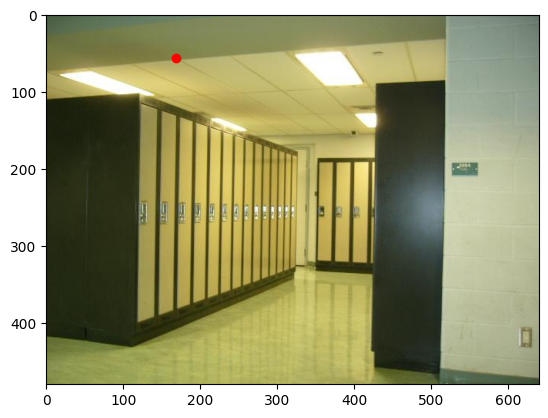

In [26]:
# plot
for pt in vp:
    plt.plot(int(pt[0][0]), int(pt[0][1]), marker = 'o', color='red')
    print(pt[0][0],pt[0][1])
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

1081.3333333333333 -86180.66666666667
1106.2551984877127 63.99054820415879
168.65693531649947 56.76630923555863


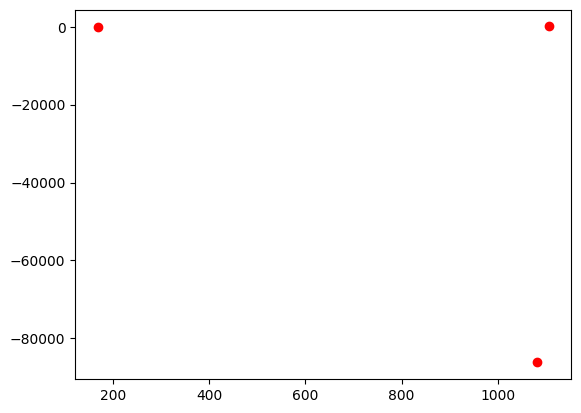

In [27]:
# plot
for pt in vp:
    plt.plot(int(pt[0][0]), int(pt[0][1]), marker = 'o', color='red')
    print(pt[0][0],pt[0][1])
plt.show()